In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')

plt.style.use('dark_background')
np.random.seed(123)
torch.manual_seed(123)

In [67]:
class LSTMModel(tf.keras.Model):
    def __init__(
        self, hidden_size, num_tasks, recurrent_dropout=0, dropout=0,
    ):
        """
        :param hidden_size: [int] the number of hidden units
        :param num_tasks: [int] number of outputs to predict 
        :param recurrent_dropout: [float] value between 0 and 1 for the
        probability of a recurrent element to be zero
        :param dropout: [float] value between 0 and 1 for the probability of an
        input element to be zero
        """
        super().__init__()
        self.rnn_layer = layers.LSTM(
            hidden_size,
            return_sequences=True,
            recurrent_dropout=recurrent_dropout,
            dropout=dropout,
        )
        self.dense = layers.Dense(num_tasks)

    @tf.function
    def call(self, inputs):
        h = self.rnn_layer(inputs)
        prediction = self.dense(h)
        return prediction
    
    
def expected_gradients_tf(x, x_set, model, n_samples, temporal_focus=None,task_focus=1):

    n_series = x_set.shape[0]
    num_vars = x_set.shape[2]
    seq_len = x_set.shape[1]
    
    for k in range(n_samples):
        # SAMPLE A SERIES FROM OUR DATA
        rand_seq = np.random.choice(n_series) # rand_time may be more accurate
        baseline_x = x_set[rand_seq]

        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        #print(x_diff)
        curr_x = baseline_x + scale*x_diff
        curr_x = tf.convert_to_tensor(curr_x)
        with tf.GradientTape() as gtape:
            gtape.watch(curr_x)
            if temporal_focus == None:
                y = model(curr_x)[:,:,task_focus]
            else:
                y=model(curr_x)[:,temporal_focus,task_focus]

        gradients = gtape.gradient(y, curr_x, tf.ones_like(y))
        #print(gradients)
        if k == 0:
            expected_gradients = x_diff*gradients * 1/n_samples
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients) * 1/n_samples)
        return(expected_gradients.numpy())

### Load in the model and the data

In [76]:
#tf.compat.v1.disable_eager_execution()
## Define some general arguments for the notebook
grad_steps = 500 #Number of steps to take in calculation of IG
weights_file = '../test_data/DO_LSTM/train_weights/'
prepped_file = '../test_data/DO_LSTM/prepped.npz'

prepped = np.load(prepped_file)
x_vars = prepped['x_vars']
num_vars = len(x_vars)
num_tasks = prepped['y_obs_trn'].shape[-1]
x_full=prepped['x_trn']
x = np.expand_dims(x_full[1,...],axis=0)

### Load our model
model = LSTMModel(10,num_tasks,.2,.2)

model.load_weights(weights_file)
## Double check the weights maps correctly
y = model.predict(x)
model.summary()
x.shape, x_full.shape, y.shape

Model: "lstm_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               multiple                  960       
                                                                 
 dense_3 (Dense)             multiple                  33        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


((1, 365, 13), (408, 365, 13), (1, 365, 3))

In [111]:
def expected_gradients_tf(x, x_set, model, n_samples, temporal_focus=None,task_focus=1):

    n_series = x_set.shape[0]
    num_vars = x_set.shape[2]
    seq_len = x_set.shape[1]
    
    for k in range(n_samples):
        # SAMPLE A SERIES FROM OUR DATA
        rand_seq = np.random.choice(n_series) # rand_time may be more accurate
        baseline_x = x_set[rand_seq]

        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        #print(x_diff)
        curr_x = baseline_x + scale*x_diff
        curr_x = tf.convert_to_tensor(curr_x)
        with tf.GradientTape() as gtape:
            gtape.watch(curr_x)
            if temporal_focus == None:
                y = model(curr_x)[:,:,task_focus]
            else:
                y=model(curr_x)[:,temporal_focus,task_focus]

        gradients = gtape.gradient(y, curr_x, tf.ones_like(y))
        #print(gradients)
        if k == 0:
            expected_gradients = x_diff*gradients * 1/n_samples
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients) * 1/n_samples)
        return(expected_gradients.numpy())


In [114]:
EG_vals = expected_gradients_tf(x, x_full, model, n_samples=4, temporal_focus=-1)

0.3199537355502095

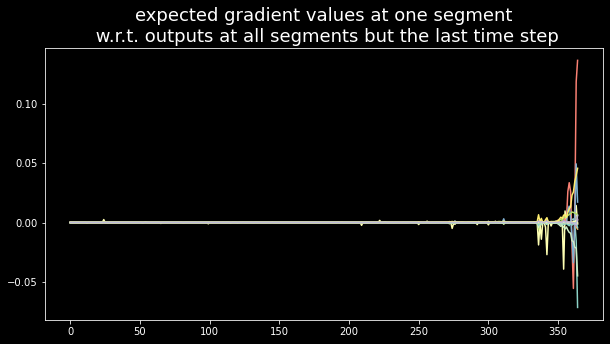

In [115]:
plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(EG_vals[0, :, i])
plt.title('expected gradient values at one segment\n w.r.t. outputs at all segments but the last time step',
          fontsize = 18);

np.sum(EG_vals.flatten())